# Pneumonia CXR Classification

<center><img src="https://i.imgur.com/jZqpV51.png" width="500"/></center>


Illustrative Examples of Chest X-Rays in Patients with Pneumonia.
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs. (From Kaggle)

**Content:**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

## Examining the data

### Imports and opening an image

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import os
from PIL import Image
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
# %matplotlib inline

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

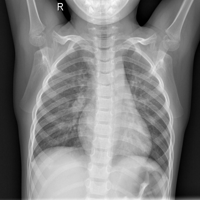

In [2]:
with Image.open('data/train/NORMAL/IM-0115-0001.jpeg') as im:
    im_resized = im.resize((200, 200))
    display(im_resized)

### Inspect the amount of 'Normal' and 'Pneumonia' cases

In [3]:
path = 'data/'
img_names = []
count_normal = 0 
count_pneumonia = 0 

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

        if 'PNEUMONIA' in folder:
            count_pneumonia += 1
        elif 'NORMAL' in folder:
            count_normal += 1

print('Images: ', len(img_names))
print('Normal count:', count_normal)
print('Pneumonia count:', count_pneumonia)

Images:  5859
Normal count: 1583
Pneumonia count: 4273


Unbalances classes

### Check the size of the images:

In [4]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  5856
Rejects: 3


In [5]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    5856.000000
mean     1327.880806
std       363.500922
min       384.000000
25%      1056.000000
50%      1281.000000
75%      1560.000000
max      2916.000000
Name: 0, dtype: float64

In [6]:
# Run summary statistics on image heights
df[1].describe()

count    5856.000000
mean      970.689037
std       383.392117
min       127.000000
25%       688.000000
50%       888.000000
75%      1187.000000
max      2713.000000
Name: 1, dtype: float64

This tells us the shortest width is 384, the shortest height is 127, the largest width and height are 2916 qnd 2713. We will resize all to 224x224 otherwise training will take very long.

## Creating the transformers

**As we do not have that many images to train the data on, we will perform data agmentation by performing the following modifications: horizontal flips, slight rotation of the images, and brightness/contrast variations, in each training epoch.**

torch.Size([1, 224, 224])


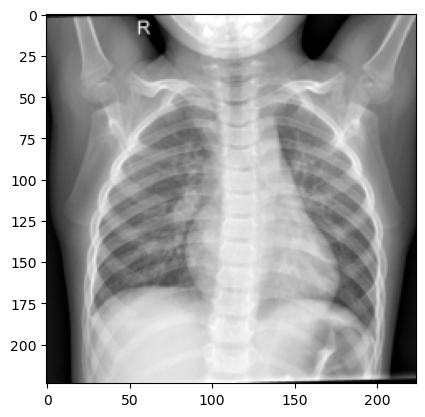

In [7]:
picture = Image.open('data/train/NORMAL/IM-0115-0001.jpeg')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),  # rotate randomly between +/- 5 degrees
    transforms.Resize(224), # Resizes larger dimension to 224 px 
    transforms.CenterCrop(224), # Makes it squared
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 0.5 probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Brightness and contrast can vary +/- 20%
    transforms.Grayscale(num_output_channels=1), # Mantains channels to 1 
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Mapping [0, 1] to [-1, 1], gradientes behave better with zero-centered outputs
])
im = train_transform(picture)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray');

Our de-normalizator:

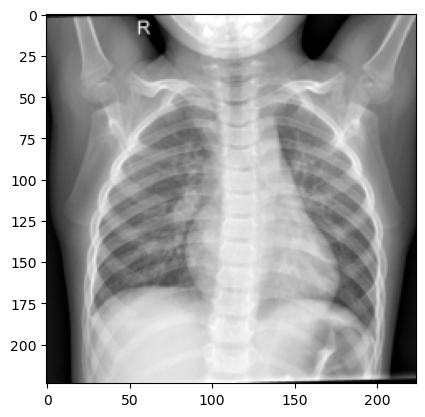

In [8]:
inv_normalize = transforms.Normalize(
    mean=[-1],
    std=[2]
)

inv_normalize(im)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray');

Out test transformer (we remove the flips, rotations and brightness/contrast modifications)

In [9]:
test_transform = transforms.Compose([
    transforms.Resize(224), # Resizes larger dimension to 224 px 
    transforms.CenterCrop(224), # Makes it squared
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Mapping [0, 1] to [-1, 1], gradientes behave better with zero-centered outputs
])

## Loading the data, preparing train, validation and test sets

In [10]:
root = 'data'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=624, shuffle=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Validation images available: {len(val_data)}')
print(f'Testing images available:  {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Training images available: 5216
Validation images available: 16
Testing images available:  624


Display a bunch of images:

Label: [0 1 0 1 1 1 0 1 1 1]
Class: NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA


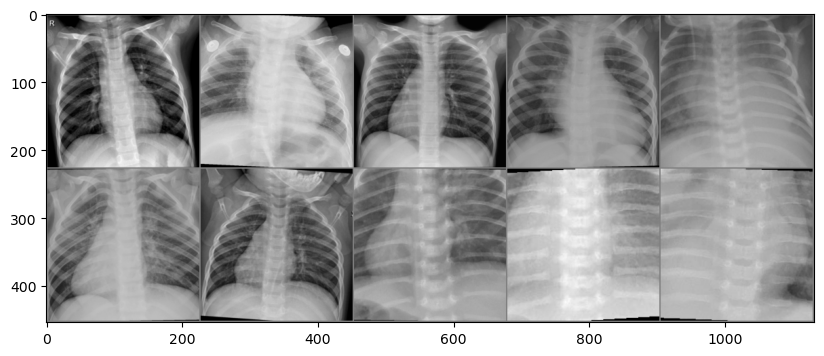

In [11]:
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels[:-6].numpy())
print('Class:', *np.array([class_names[i] for i in labels[:-6]]))

from torchvision.utils import make_grid

im = make_grid(images[:-6], nrow=5)  # the default nrow is 8

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Define the convolutional model, loss and optimization funcitons

#### Model architecture:    

**Imput:** [B, 1, 224, 224]

**Conv1:** 6 filters of 5x5, stride 1, no padding. Output: [B, 6, 220, 220] -> **ReLu**.

**MaxPool:** 2x2, stride 2 -> Output: [B, 6, 110, 110]

**Conv2:** 16 filters of 5x5, stride 1, no padding. Output: [B, 16, 106, 106] -> **ReLu**.

**MaxPool:** 2x2, stride 2 -> Output: [B, 16, 53, 53]

**Flatten:** 16×53×53 = 44,944 features

**FC1:**  44,944 -> 120 -> **ReLu**

**FC2:**  120 -> 80 -> **ReLu**

**FC3:**  80 -> 2 -> **LogSoftmax** over the 2 classes

In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 53*53*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [13]:
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

To account for the imbalance of the two classes in the training set, we pass on weights to the loss function

In [14]:
CNNmodel = ConvolutionalNetwork()


targets = np.array(train_data.targets) 
counts  = np.bincount(targets)
w0 = len(targets) / (2.0 * counts[0])
w1 = len(targets) / (2.0 * counts[1])
class_weights = torch.tensor([w0, w1], dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(CNNmodel)

     150
       6
    2400
      16
 5393280
     120
    9600
      80
     160
       2
________
 5405814


## Train the model

In [16]:
import time
start_time = time.time()

epochs = 3

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    val_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print intermediate results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{16*b:6}/5216]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(16*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            
            # Apply the model
            y_pred = CNNmodel(X_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1] 
            val_corr += (predicted == y_val).sum()

    loss = criterion(y_pred, y_val)
    val_losses.append(loss.item())
    val_correct.append(val_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   160/5216]  loss: 0.36903161  accuracy:  65.000%
epoch:  0  batch:   20 [   320/5216]  loss: 0.23065679  accuracy:  76.250%
epoch:  0  batch:   30 [   480/5216]  loss: 1.38519156  accuracy:  78.958%
epoch:  0  batch:   40 [   640/5216]  loss: 0.35775512  accuracy:  80.312%
epoch:  0  batch:   50 [   800/5216]  loss: 0.35042048  accuracy:  82.125%
epoch:  0  batch:   60 [   960/5216]  loss: 0.53263766  accuracy:  83.125%
epoch:  0  batch:   70 [  1120/5216]  loss: 0.26922405  accuracy:  83.571%
epoch:  0  batch:   80 [  1280/5216]  loss: 0.20157778  accuracy:  84.922%
epoch:  0  batch:   90 [  1440/5216]  loss: 0.24874642  accuracy:  85.208%
epoch:  0  batch:  100 [  1600/5216]  loss: 0.48671722  accuracy:  85.500%
epoch:  0  batch:  110 [  1760/5216]  loss: 0.36082587  accuracy:  84.716%
epoch:  0  batch:  120 [  1920/5216]  loss: 0.16072264  accuracy:  85.208%
epoch:  0  batch:  130 [  2080/5216]  loss: 0.15858604  accuracy:  85.962%
epoch:  0  batch:  140 [ 

### Save the trained model:

In [17]:
torch.save(CNNmodel.state_dict(), 'models/Pneumonia_CNNModel.pt')

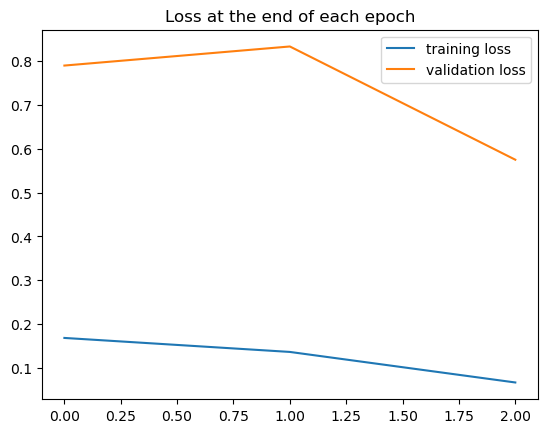

In [18]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

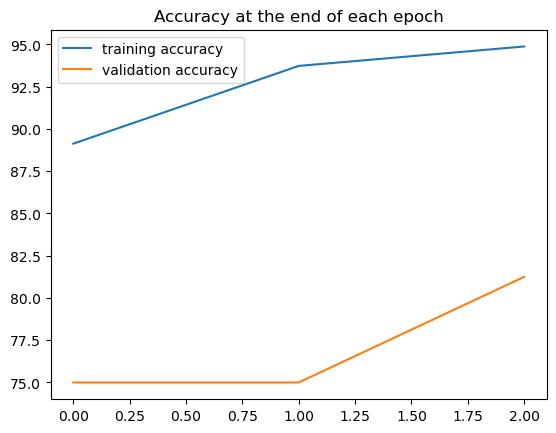

In [19]:
plt.plot([t/5216*100 for t in train_correct], label='training accuracy')
plt.plot([t/16*100 for t in val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [20]:
print(val_correct)
print(f'Validation accuracy: {val_correct[-1].item()*100/16:.3f}%')

[tensor(12), tensor(12), tensor(13)]
Validation accuracy: 81.250%


## Evaluate Test Data

In [21]:
CNNmodel = ConvolutionalNetwork()
CNNmodel.load_state_dict(torch.load("models/Pneumonia_CNNModel.pt"))
CNNmodel.eval()                            # eval mode for inference

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [22]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_pred = CNNmodel(X_test) 
        predicted = torch.max(y_pred, 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 490/624 =  78.526%


### Display the confussion matrix and classification report

In [23]:
# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[118  18]
 [116 372]]


In [24]:
print(classification_report(predicted.view(-1), y_test.view(-1)))

              precision    recall  f1-score   support

           0       0.50      0.87      0.64       136
           1       0.95      0.76      0.85       488

    accuracy                           0.79       624
   macro avg       0.73      0.81      0.74       624
weighted avg       0.86      0.79      0.80       624



## Conclusions and insights

**Model:** We trained a compact convolutional network, with two 5×5 conv layers (1→6, 6→16) + two 2×2 max-pools, followed by three fully connected layers (44,944→120→80→2) with LogSoftmax. 

**Input:** 1-channel 224×224 CXR, normalized to ~[−1, 1].

We performed **augmentations** (small rotations, mild brightness/contrast) in the training set to reduce overfitting and improve robustness.

To mitigate the NORMAL (minority) vs PNEUMONIA (majority) **imbalance**, we use inverse-frequency weights in CrossEntropyLoss (computed on the training set):


**Test results**

- Accuracy: 0.79

- Per-class

    NORMAL — Precision 0.50, Recall 0.87, F1 0.64 (support 136)
  
    PNEUMONIA — Precision 0.95, Recall 0.76, F1 0.85 (support 488)
- Macro avg F1: 0.74; Weighted avg F1: 0.80


**The model is very conservative when calling Pneumonia: high precision (0.97) but lower recall (0.76) → it misses 121 pneumonías (false negatives), which is undesirable in a screening context.**